enter iccg_solve
Dof= 228    matrix size= 1915.0
shift parameter= 1.0
minimum residual= 2.1991609412171096e-16  at iteraions:  33
結果のノルム: 1.282737706397149e-09
power=  31116096318.073036
enter iccg_solve
Dof= 5620    matrix size= 179805.0
shift parameter= 1.0
minimum residual= 1.106931713811232e-08  at iteraions:  34


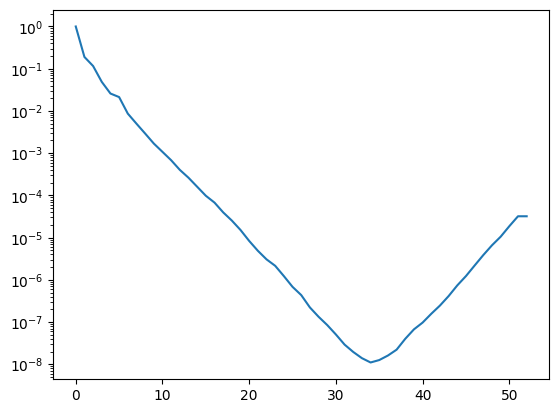

結果のノルム: 1.2224667578017136e-05
power=  25143.090431216056
 Omega field


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Bfield


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

center magnetic field =  (2.9832600030887388e-05, -0.6667063321475687, -2.2817445561319563e-06)


In [1]:
from netgen.meshing import *
from netgen.csg import *
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\model')
from Cylinder_Yaxis_1Layer import Cylinder_Yaxis_1Layer
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
from HtoOmega import HtoOmega

model=Cylinder_Yaxis_1Layer(ndiv=3, muiron=1, curveOrder=1)
mesh=model.mesh
symmetric_plane=model.symmetric_plane
Mu=model.Mu
reduced_region=model.reduced_region
total_region=model.total_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary

Dirichlet=False
feorder=3
mu=4.e-7*math.pi

#field=UNIF(0,1,0,0)
field=LINE(1.e6, 0.3, 0,0, 0,0,1)
#Ov=Ofield(field)
Bv=Bfield(field)
Hv=Bv/mu
#Os=model.ReducedField(Ov, 0)
Bs=model.ReducedField(Bv, (0,0,0))

if Dirichlet==True:
    fesOmega=H1(mesh, order=feorder, dirichlet=reduced_boundary)
else:
    fesOmega=H1(mesh, order=feorder)
    
omega,psi = fesOmega.TnT() 
gfOmega = GridFunction(fesOmega)
a= BilinearForm(fesOmega)
a +=Mu*(grad(omega)*grad(psi))*dx
with TaskManager():
    a.Assemble()
normal = specialcf.normal(mesh.dim)

surfaceOmega=HtoOmega(mesh, total_boundary, feorder, Hv)
#surfaceOmega=y
# Calculate Dirichlet condition terms
#gfOmega.Set(Ov, BND, mesh.Boundaries(total_boundary))
gfOmega.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))

f = LinearForm(fesOmega)
f +=Mu*grad(gfOmega)*grad(psi)*dx(reduced_region)
#f +=-Mu*grad(gfOmega)*grad(psi)*dx(total_region)
with TaskManager():
    f.Assemble() 
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesOmega.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesOmega.FreeDofs()] = fcut

# Add Neumann condition terms

dOmega=Integrate((normal*Bv)*ds(total_boundary), mesh)
da=Integrate((normal*normal)*ds(total_boundary), mesh)
dOmega =dOmega/da
#print("da=", da, "   dOmega=", dOmega)
#f += (normal*Bv)*psi*ds(total_boundary)
f  += (normal*(Bv-dOmega*normal))*psi*ds(total_boundary)
with TaskManager():
    f.Assemble()
gfOmega = GridFunction(fesOmega)   #Clear gfOmega
gfOmega=solver.iccg_solve(fesOmega, gfOmega, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=1.0,
                          complex=False, logplot=True) 

fesOt=H1(mesh, order=feorder, definedon=total_region)
fesOr=H1(mesh, order=feorder, definedon=reduced_region)
Ot=GridFunction(fesOt)
Orr=GridFunction(fesOr)
Oxr=GridFunction(fesOr)

Ot.Set(gfOmega,VOL, definedon=total_region)
Orr.Set(gfOmega,VOL, definedon=reduced_region)
Oxr.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))

Bt=grad(Ot)*Mu
Or=Orr-Oxr
Br=(grad(Orr)-grad(Oxr))*mu

print(" Omega field" )
Draw ((Ot+Or)*mu, mesh, order=3, min=0., max=1.0, deformation=False)       

Bfield=Bt+Br+Bs
print("Bfield")
Draw (Bfield, mesh, order=3, min=0.5, max=1.5, deformation=False)

mip = mesh(0,0,0)
print("center magnetic field = ", Bfield(mip))




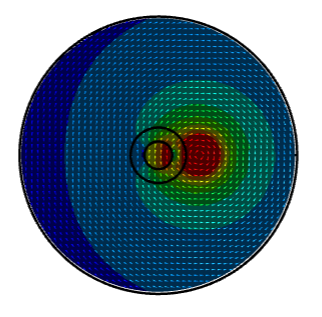
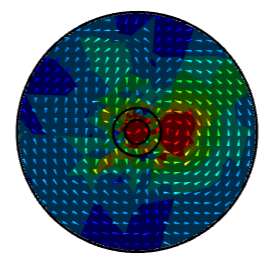

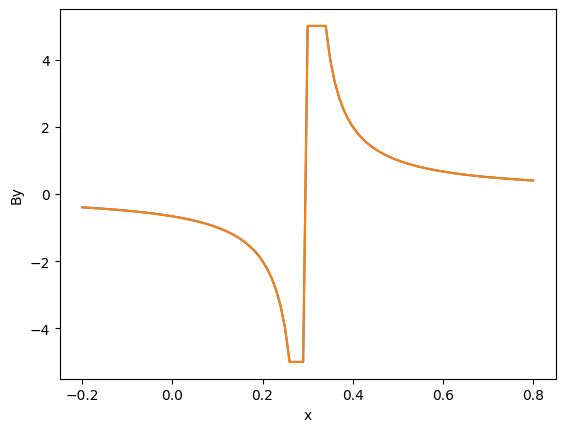

In [2]:
import matplotlib.pylab as plt
x0=-0.2
y0=0
z0=0
dx=1/100
x=x0
y=y0
z=z0
xp=[]
ypreal=[]
ypimag=[]
ana=[]
for n in range(101):
    pnt=mesh(x,y,z)
    #print( "x= ", x, "  Bz= ", Bfield(pnt)[2].real, "  ", Bfield(pnt)[2].imag)
    xp.append(x)
    val=Bfield(pnt)[1]
    if val>5: val=5
    if val<-5: val=-5
    ypreal.append(val)
    val=2.e-7/(x-0.3)*1.e6
    if val>5: val=5
    if val<-5: val=-5    
    ana.append(val)
    x=x+dx

plt.plot(xp, ypreal ) 
plt.plot(xp, ana)
plt.xlabel("x")  # Add x-axis label
#plt.ylabel("Bz")  # Add y-axis label
plt.ylabel("By")  # Add y-axis label
plt.show()  

Dirichlet=False

center magnetic field =  (5.667939415855817e-08, 1.8034297051795165, 2.842349898372076e-12)

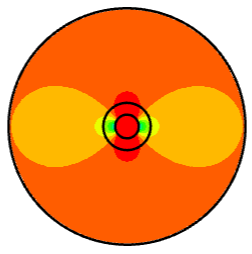

Dirichlet=True

center magnetic field =  (5.857076949050397e-08, 1.8331838248112047, 2.839408043562641e-12)

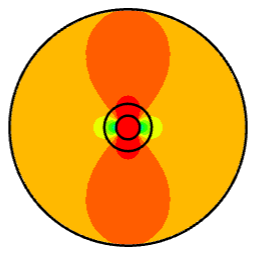